In [20]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 21490.32it/s]


In [22]:
dataset[:10]

[('21 march 1973', '1973-03-21'),
 ('sunday july 8 2012', '2012-07-08'),
 ('thursday april 9 2015', '2015-04-09'),
 ('8/10/96', '1996-08-10'),
 ('monday january 22 1990', '1990-01-22'),
 ('wednesday may 5 1976', '1976-05-05'),
 ('05 jun 2017', '2017-06-05'),
 ('8 09 81', '1981-09-08'),
 ('friday december 17 2010', '2010-12-17'),
 ('thursday may 31 2001', '2001-05-31')]

In [23]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [24]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 21 march 1973
Target date: 1973-03-21

Source after preprocessing (indices): [ 5  4  0 24 13 28 15 20  0  4 12 10  6 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10  8  4  0  1  4  0  3  2]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [25]:
repeator=RepeatVector(Tx)
concatenator=Concatenate(axis=-1)
densor1=Dense(10,activation='tanh')
densor2=Dense(1,activation='relu')
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

```context=dotor(alphas,a)```改为 ```     context=dotor([alphas,a])```

In [26]:
def one_step_attention(a,s_prev):
    s_prev=repeator(s_prev)
#     concat=concatenator([s_prev,a])
    concat=concatenator([a,s_prev])
    e=densor1(concat)
    energies=densor2(e)
    alphas=activator(energies)
    context=dotor([alphas,a])
    return context
    
    
    

In [27]:
n_a=32
n_s=64
post_activation_LSTM_cell=LSTM(n_s,return_state=True)
output_layer=Dense(len(machine_vocab),activation=softmax)

####  双向LSTM:  应该是嵌套关系（外层Bidirectional，内层LSTM）
- 错误

```
    a=Bidirectional(n_s,return_state=True)

```
- 正确

```
    a=Bidirectional(LSTM(n_s,return_state=True))

```


#### bug

```
<ipython-input-116-57255807c600> in one_step_attention(a, s_prev)
      2     s_prev=RepeatVector(s_prev)
      3 #     concat=concatenator([s_prev,a])
----> 4     concat=concatenator([a,s_prev])
      5     e=densor1(concat)
      6     energies=densor2(e)

~/miniconda3/lib/python3.6/site-packages/keras/engine/topology.py in __call__(self, inputs, **kwargs)
    556                 # Raise exceptions in case the input is not compatible
    557                 # with the input_spec specified in the layer constructor.
--> 558                 self.assert_input_compatibility(inputs)
    559 
    560                 # Collect input shapes to build layer.

~/miniconda3/lib/python3.6/site-packages/keras/engine/topology.py in assert_input_compatibility(self, inputs)
    429                                  'Received type: ' +
    430                                  str(type(x)) + '. Full input: ' +
--> 431                                  str(inputs) + '. All inputs to the layer '
    432                                  'should be tensors.')
    433 

ValueError: Layer concatenate_3 was called with an input that isn't a symbolic tensor. Received type: <class 'keras.layers.core.RepeatVector'>. Full input: [<tf.Tensor 'bidirectional_14/concat_2:0' shape=(?, ?, 128) dtype=float32>, <keras.layers.core.RepeatVector object at 0x7f65a7af1c18>]. All inputs to the layer should be tensors.

```


#### 【bug】`a=Bidirectional(LSTM(n_s,return_state=True),input_shape=(m,Tx,n_a*2))(X) `中 `return_state=True` 改为 `return_sequence=True`

```
<ipython-input-103-060c318cc92f> in model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size)
      6     c=c0
      7 
----> 8     a=Bidirectional(LSTM(n_s,return_state=True),input_shape=(m,Tx,n_a*2))(X)
      9 
     10     outputs=[]
     
~/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py in ndim(x)
    542     
    543     """
--> 544     dims = x.get_shape()._dims
    545     if dims is not None:
    546         return len(dims)

AttributeError: 'list' object has no attribute 'get_shape'     
```

#### 【bug】系数比预期 `(None, 30, 64) `翻了一番
```
bidirectional_1 (Bidirectional)  (None, 30, 128) 
```

In [28]:
def model(Tx,Ty,n_a,n_s,human_vocab_size,machine_vocab_size):
    X=Input(shape=(Tx,human_vocab_size))
    s0=Input(shape=(n_s,),name='s0')
    c0=Input(shape=(n_s,),name='c0')
    s=s0
    c=c0
    
    a=Bidirectional(LSTM(n_a,return_sequences=True),input_shape=(m,Tx,n_a*2))(X)
    
    outputs=[]
    
    for t in range(Ty):    
        context=one_step_attention(a,s)
        s,_,c=post_activation_LSTM_cell(context,initial_state=[s,c])
        out=output_layer(s)
        outputs.append(out)
        
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

In [29]:
model=model(Tx,Ty,n_a,n_s,len(human_vocab),len(machine_vocab))

In [30]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 30, 64)        17920       input_2[0][0]                    
____________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_3[0][0]            

In [31]:
opt=Adam(lr=0.005,beta_1=0.9,beta_2=0.999,decay=0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [32]:
s0=np.zeros((m,n_s))
c0=np.zeros((m,n_s))
outputs=list(Yoh.swapaxes(0,1))

In [33]:
model.fit([Xoh, s0, c0], outputs, epochs=50, batch_size=100)

Epoch 1/50
10000/10000 [==============================] - 13s - loss: 16.8011 - dense_6_loss_1: 1.1405 - dense_6_loss_2: 0.9764 - dense_6_loss_3: 1.7010 - dense_6_loss_4: 2.6880 - dense_6_loss_5: 0.8111 - dense_6_loss_6: 1.3757 - dense_6_loss_7: 2.7021 - dense_6_loss_8: 1.0605 - dense_6_loss_9: 1.7320 - dense_6_loss_10: 2.6139 - dense_6_acc_1: 0.5447 - dense_6_acc_2: 0.7282 - dense_6_acc_3: 0.3114 - dense_6_acc_4: 0.0740 - dense_6_acc_5: 0.9633 - dense_6_acc_6: 0.3013 - dense_6_acc_7: 0.0509 - dense_6_acc_8: 0.8825 - dense_6_acc_9: 0.2584 - dense_6_acc_10: 0.1031    
Epoch 2/50
10000/10000 [==============================] - 11s - loss: 9.0614 - dense_6_loss_1: 0.1354 - dense_6_loss_2: 0.1135 - dense_6_loss_3: 1.0192 - dense_6_loss_4: 2.1661 - dense_6_loss_5: 0.0338 - dense_6_loss_6: 0.3928 - dense_6_loss_7: 1.8798 - dense_6_loss_8: 0.0229 - dense_6_loss_9: 1.1416 - dense_6_loss_10: 2.1563 - dense_6_acc_1: 0.9702 - dense_6_acc_2: 0.9708 - dense_6_acc_3: 0.5209 - dense_6_acc_4: 0.2074 - 

10000/10000 [==============================] - 11s - loss: 0.9168 - dense_6_loss_1: 0.0387 - dense_6_loss_2: 0.0164 - dense_6_loss_3: 0.0711 - dense_6_loss_4: 0.1063 - dense_6_loss_5: 0.0029 - dense_6_loss_6: 0.0447 - dense_6_loss_7: 0.2373 - dense_6_loss_8: 0.0043 - dense_6_loss_9: 0.2617 - dense_6_loss_10: 0.1335 - dense_6_acc_1: 0.9868 - dense_6_acc_2: 0.9946 - dense_6_acc_3: 0.9918 - dense_6_acc_4: 0.9968 - dense_6_acc_5: 1.0000 - dense_6_acc_6: 0.9871 - dense_6_acc_7: 0.9341 - dense_6_acc_8: 1.0000 - dense_6_acc_9: 0.9134 - dense_6_acc_10: 0.9684    
Epoch 16/50
10000/10000 [==============================] - 11s - loss: 0.8282 - dense_6_loss_1: 0.0356 - dense_6_loss_2: 0.0135 - dense_6_loss_3: 0.0592 - dense_6_loss_4: 0.0908 - dense_6_loss_5: 0.0025 - dense_6_loss_6: 0.0420 - dense_6_loss_7: 0.2217 - dense_6_loss_8: 0.0038 - dense_6_loss_9: 0.2402 - dense_6_loss_10: 0.1189 - dense_6_acc_1: 0.9880 - dense_6_acc_2: 0.9958 - dense_6_acc_3: 0.9933 - dense_6_acc_4: 0.9986 - dense_6_acc

10000/10000 [==============================] - 11s - loss: 0.3298 - dense_6_loss_1: 0.0161 - dense_6_loss_2: 0.0035 - dense_6_loss_3: 0.0145 - dense_6_loss_4: 0.0265 - dense_6_loss_5: 0.0010 - dense_6_loss_6: 0.0227 - dense_6_loss_7: 0.1041 - dense_6_loss_8: 0.0023 - dense_6_loss_9: 0.0966 - dense_6_loss_10: 0.0425 - dense_6_acc_1: 0.9972 - dense_6_acc_2: 0.9996 - dense_6_acc_3: 0.9996 - dense_6_acc_4: 0.9999 - dense_6_acc_5: 1.0000 - dense_6_acc_6: 0.9928 - dense_6_acc_7: 0.9696 - dense_6_acc_8: 1.0000 - dense_6_acc_9: 0.9782 - dense_6_acc_10: 0.9935    
Epoch 30/50
10000/10000 [==============================] - 12s - loss: 0.3075 - dense_6_loss_1: 0.0154 - dense_6_loss_2: 0.0032 - dense_6_loss_3: 0.0133 - dense_6_loss_4: 0.0253 - dense_6_loss_5: 9.9209e-04 - dense_6_loss_6: 0.0199 - dense_6_loss_7: 0.0986 - dense_6_loss_8: 0.0022 - dense_6_loss_9: 0.0888 - dense_6_loss_10: 0.0399 - dense_6_acc_1: 0.9972 - dense_6_acc_2: 0.9997 - dense_6_acc_3: 0.9995 - dense_6_acc_4: 0.9999 - dense_6

10000/10000 [==============================] - 11s - loss: 0.1549 - dense_6_loss_1: 0.0088 - dense_6_loss_2: 0.0016 - dense_6_loss_3: 0.0067 - dense_6_loss_4: 0.0129 - dense_6_loss_5: 5.7192e-04 - dense_6_loss_6: 0.0105 - dense_6_loss_7: 0.0538 - dense_6_loss_8: 0.0015 - dense_6_loss_9: 0.0397 - dense_6_loss_10: 0.0189 - dense_6_acc_1: 0.9989 - dense_6_acc_2: 0.9998 - dense_6_acc_3: 0.9999 - dense_6_acc_4: 1.0000 - dense_6_acc_5: 1.0000 - dense_6_acc_6: 0.9975 - dense_6_acc_7: 0.9878 - dense_6_acc_8: 1.0000 - dense_6_acc_9: 0.9949 - dense_6_acc_10: 0.9983    
Epoch 44/50
10000/10000 [==============================] - 11s - loss: 0.1482 - dense_6_loss_1: 0.0085 - dense_6_loss_2: 0.0015 - dense_6_loss_3: 0.0065 - dense_6_loss_4: 0.0123 - dense_6_loss_5: 5.5718e-04 - dense_6_loss_6: 0.0103 - dense_6_loss_7: 0.0516 - dense_6_loss_8: 0.0014 - dense_6_loss_9: 0.0378 - dense_6_loss_10: 0.0179 - dense_6_acc_1: 0.9988 - dense_6_acc_2: 0.9998 - dense_6_acc_3: 0.9999 - dense_6_acc_4: 1.0000 - den

In [34]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-04
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


In [35]:
model.load_weights('models/model.h5')

EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 30, 64)        17920       input_2[0][0]                    
____________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_3[0][0]            

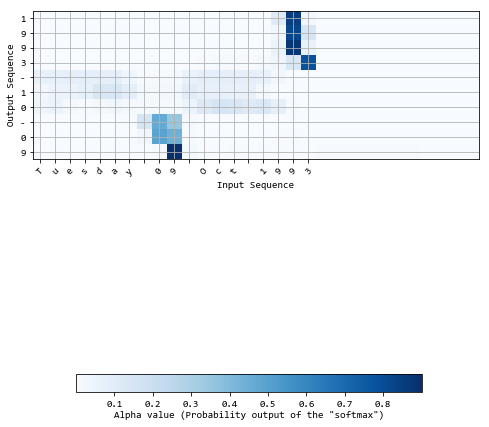

In [37]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)